In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import random
import os
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

### Import the dataset and find the path of images

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
test_df = pd.read_csv('test.csv')

In [4]:
# check for duplicates, no duplicates found
train_df[train_df.duplicated(keep = False)]

,id,boneage,male


In [5]:
# check for duplicates, no duplicates found
test_df[test_df.duplicated(keep = False)]

,id,male,boneage


In [6]:
# image file directory
img_dir = r'C:\Users\stron\Desktop\290 Project\Bone Age Training Set'
test_img_dir = r'C:\Users\stron\Desktop\290 Project\Bone Age Test Set'

In [7]:
def return_filepath(name, folder=img_dir):
    path = os.path.join(folder, f'{name}.png')
    return path

In [8]:
# find the file path for each image
train_df['image_path'] = train_df.iloc[:, 0].apply(lambda x: return_filepath(x))
test_df['image_path'] = test_df.iloc[:, 0].apply(lambda x: return_filepath(x, test_img_dir))

In [9]:
train_df['male'] = train_df['male'].astype(int)
test_df['male'] = test_df['male'].astype(int)

In [10]:
train_df.head(10)

,id,boneage,male,image_path
0,1377,180,0,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
1,1378,12,0,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
2,1379,94,0,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
3,1380,120,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
4,1381,82,0,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
5,1382,138,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
6,1383,150,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
7,1384,156,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
8,1385,36,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...
9,1387,138,1,C:\Users\stron\Desktop\290 Project\Bone Age Tr...


In [11]:
test_df.head(5)

,id,male,boneage,image_path
0,1386,0,30,C:\Users\stron\Desktop\290 Project\Bone Age Te...
1,1392,1,162,C:\Users\stron\Desktop\290 Project\Bone Age Te...
2,1397,0,18,C:\Users\stron\Desktop\290 Project\Bone Age Te...
3,1401,0,132,C:\Users\stron\Desktop\290 Project\Bone Age Te...
4,1410,1,57,C:\Users\stron\Desktop\290 Project\Bone Age Te...


In [12]:
# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

In [13]:
class RadiologyDataset(Dataset):
    
    def __init__(self, images_filepaths, male_features, bone_ages, transform):
        self.images_filepaths = images_filepaths
        self.male_features = male_features
        self.bone_ages = bone_ages
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]        
        img_cv2 = cv2.imread(image_filepath)
        image = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB) # only this method read the image as black/white
      
        # Convert the color image to LAB color space. 
        # Lab color space is a 3-axis color system with dimension L for lightness and a and b for the color dimensions.
        lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        # Apply CLAHE to the L channel. L represents lightness from black to white on a scale of zero to 100
        lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])
        # Convert back to RGB color space
        enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
      
        # Apply zooming
        if self.transform is not None:
            enhanced_image = self.transform(enhanced_image)
    
         # Example: Convert to tensor and normalize
        image = enhanced_image.permute(2, 0, 1).float() / 255.0
        male = self.male_features[idx]
        label = torch.tensor(self.bone_ages[idx])

        return image, male, label

In [14]:
# tranformation that converts images into tensors
img_transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop((2000, 1200)),
                                      transforms.Resize((512,512)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=30),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.2, hue=0.5),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      #transforms.Lambda(lambda img: crop_blank(img)),
                                      #transforms.RandomCrop((512,512), padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),  
                                      #transforms.FiveCrop(2000),
                                      #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                                      #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                      #transforms.RandomVerticalFlip(p=0.5),
                                      #transforms.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10),
                                     ])

In [15]:
# train df
X_train = train_df['image_path']
X_train_male = train_df['male'] # important feature in predicting bone age
y_train = train_df['boneage'] # do we need to normalize the bone age?

In [16]:
# train
train_dataset = RadiologyDataset(
    images_filepaths = X_train.values,
    male_features = X_train_male.values,
    bone_ages = y_train.values,
    transform = img_transformer
)

In [17]:
# test df
X_test = test_df['image_path']
X_test_male = test_df['male'] # important feature in predicting bone age
y_test = test_df['boneage'] 

In [18]:
# test
test_dataset = RadiologyDataset(
    images_filepaths = X_test.values,
    male_features = X_test_male.values,
    bone_ages = y_test.values,
    transform = img_transformer
)

In [19]:
# an example tensor
img, male, label = train_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([512, 3, 512]) tensor(0.0004) tensor(0.0030)


In [20]:
# check the test set
img, male, label = test_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([512, 3, 512]) tensor(1.6561e-05) tensor(0.0032)


TypeError: Invalid shape (3, 512, 512) for image data

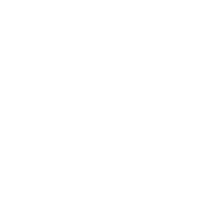

In [25]:
def plot_img(train_dataset_p = train_dataset, inline=5):
    plt.figure(figsize=(20,10))
    j = 0
    for i in range(inline):
        image, dense, label = train_dataset_p[j]
        plt.subplot(1, inline, i%inline+1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'Bone Age: {label}')
        j = j + 1

TypeError: Invalid shape (512, 3, 512) for image data

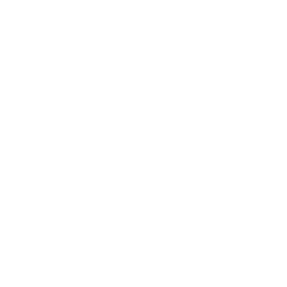

In [22]:
plot_img(inline = 5)

In [ ]:
# train validation split
len_img = len(train_dataset)
len_train = len_img - 700
len_val = 700

# split the tensor
train_dataset, val_dataset = random_split(train_dataset, [len_train, len_val]) # validation size 0.25?

print("train dataset size:", len(train_dataset))
print("validation dataset size:", len(val_dataset))

In [ ]:
# create dataloaders
train_val_batch_size = 32
test_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = train_val_batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = train_val_batch_size, num_workers = 0)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, num_workers = 0)

## Define the neural network

In [ ]:
lr = 0.001 # learning rate

# Define the neural network 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*64*64+1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x, male):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64*64*64) # reshape
        x = torch.cat([x, male.unsqueeze(1)], dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        return x

model = Network()

# initialization
for name, param in model.named_parameters():
    if 'weight' in name:
        init.kaiming_uniform_(param)
    elif 'bias' in name:
        init.constant_(param, 0.01)

In [ ]:
#import torchvision.models as models
# Load pre-trained ResNet model
#resnet_model = models.resnet18(pretrained=True)

# Modify the output layer to match the number of classes in your problem
#resnet_model.fc = nn.Linear(resnet18.fc.in_features, 1)

# Define loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training loop
#num_epochs = 10
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#resnet_model.to(device)

#for epoch in range(num_epochs):
    #for inputs, males, labels in train_loader:
        #inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        #outputs = resnet_model(inputs)

        # Calculate loss
        #loss = criterion(outputs, labels.float().view(-1, 1))

        # Backward pass and optimization
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

    #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Save the trained model
#torch.save(resnet_model.state_dict(), 'bone_age_resnet.pth')

In [ ]:
# Define your execution device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)   

In [ ]:
# function to save the model
def model_save():
    path = './nn_model_290_2.pth'
    torch.save(model.state_dict(), path)

In [ ]:
# loss function L2
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

## Training Loop

In [ ]:
t_temp = time.time()
train_loader = list(train_loader)
print(time.time()-t_temp)
#t_temp = time.time()
#val_loader = list(val_loader)
#print(time.time()-t_temp)

In [ ]:
epochs = 50
min_valid_loss = np.inf
tic = time.time()

for epoch in range(1, epochs+1):
    train_loss = 0.0
    for data in train_loader:
        image, male, labels = data
        image = image.cuda()
        male = male.cuda()
        labels = labels.unsqueeze(1).float()
        labels = labels.cuda()
    
        optimizer.zero_grad() # zero the parameter gradients
        target = model(image, male)
        loss = loss_fn(target, labels)
        loss.backward() # backpropagate the loss
        optimizer.step() # adjust the parameters
        train_loss += loss.item() # track the loss value
    
    # calculate the training loss value
    train_loss_value = train_loss / len(train_loader)
     
    valid_loss = 0.0
    model.eval()
    preds = []
    y_actual = []
    for data in val_loader:
        image, male, labels = data
        image = image.cuda()
        male = male.cuda()
        labels = labels.unsqueeze(1).float()
        labels = labels.cuda()
        
        target = model(image, male)
        loss = loss_fn(target,labels)
        valid_loss += loss.item()
        
        with torch.no_grad():
            output = model(image, male)
            preds.append(output.cpu())
            y_actual.append(labels.cpu())
        
    # calculate the validation loss value
    val_loss_value = valid_loss / len(val_loader)
    
    # calculate the validation mae
    preds = torch.cat(preds)
    preds_processed = np.array(preds.reshape(-1))
    y_actual = torch.cat(y_actual)
    y_actual_processed = np.array(y_actual.reshape(-1))
    val_mae = mean_absolute_error(y_actual_processed, preds_processed)
    
    # Save the model
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
        model_save()
        
    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Validation MAE is: %.4f' %val_mae)

tac = time.time()
print('Run time: ', round((tac - tic) / 60, 2), ' min')

## Make predictions on the test dataset

In [ ]:
model.eval()

preds = []
for data in tqdm(test_loader):
    image, male, labels = data
    image = image.cuda()
    male = male.cuda()
    labels = labels.cuda()
    
    with torch.no_grad():
        output = model(image, male)
        preds.append(output.cpu())

In [ ]:
preds = torch.cat(preds)
print(preds.shape)
preds_processed = np.array(preds.reshape(-1))
print(len(preds_processed))

In [ ]:
print('MAE: ', mean_absolute_error(y_test, preds_processed))